# For Colab

In [1]:
# --- always get latest repo state in Colab ---
import os, sys, subprocess

REPO_URL  = "https://github.com/Wmeesena/Safe_Start.git"
REPO_ROOT = "/content/Safe_Start"     # repo root
WORKDIR   = os.path.join(REPO_ROOT, "MAGIC")
BRANCH    = "main"

def run(cmd):
    print("$", " ".join(cmd))
    subprocess.run(cmd, check=True)

if not os.path.isdir(REPO_ROOT):
    run(["git", "clone", "--depth", "1", "--branch", BRANCH, REPO_URL, REPO_ROOT])
else:
    run(["git", "-C", REPO_ROOT, "fetch", "origin"])
    run(["git", "-C", REPO_ROOT, "checkout", BRANCH])
    run(["git", "-C", REPO_ROOT, "reset", "--hard", f"origin/{BRANCH}"])

# (optional) submodules
# run(["git", "-C", REPO_ROOT, "submodule", "update", "--init", "--recursive"])

# Set working dir and import path
os.chdir(WORKDIR if os.path.isdir(WORKDIR) else REPO_ROOT)
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

print("CWD:", os.getcwd())
!git -C {REPO_ROOT} rev-parse --abbrev-ref HEAD
!git -C {REPO_ROOT} rev-parse HEAD

# installs
%pip install -q ucimlrepo


$ git clone --depth 1 --branch main https://github.com/Wmeesena/Safe_Start.git /content/Safe_Start


fatal: could not create leading directories of '/content/Safe_Start': Read-only file system


CalledProcessError: Command '['git', 'clone', '--depth', '1', '--branch', 'main', 'https://github.com/Wmeesena/Safe_Start.git', '/content/Safe_Start']' returned non-zero exit status 128.

# Setup

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import torch
from src.models.mlp import MLP
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from src.train import pretrain,  joint_train, train_all
from src.eval import evaluate_avg_accuracy, evaluate_robust, eval_one, eval_all
from src.utils import pct, pct_ci
from src.plots import plot_loss_multi, plot_all_loss
from src.data import load_magic_data

%load_ext autoreload
%autoreload 2


# Data

In [52]:
SIGMA = np.sqrt(0.07)
SAMPLES_EVAL = 50
SAMPLES_TRAIN = 10
GAMMA = 1000000.
NUM_EPOCHS = 10
NUM_EPOCHS_PRE = 100

In [47]:
X_train, y_train, X_test, y_test = load_magic_data()

# Pretrain

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [49]:
model = MLP(input_size=X_train.shape[1]).to(device)
pre_model = pretrain(X_train,y_train, model, num_epochs=NUM_EPOCHS_PRE)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
_ = eval_one( pre_model, X_test, y_test, SIGMA, SAMPLES_EVAL)


Accuracy: 83.17%  (CI 95%: [82.11%, 84.18%])
Robust Accuracy: 83.13744%  (CI 95%: [82.17249%, 84.16818%])
Conditional Robust Accuracy: 99.37546%  (CI 95%: [99.24790%, 99.49636%])


In [30]:
# pre_model1, hist_pre1 = joint_train(
#             X_train, y_train, pre_model, num_epochs=1, gamma=GAMMA,
#             num_samples=SAMPLES_TRAIN, sigma=SIGMA, IF_SAFE=False,
#             opt="adam"
#         )
# _ = eval_one( pre_model1, X_test, y_test, SIGMA, 1000)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 63.96%  (CI 95%: [62.63%, 65.28%])
Robust Accuracy: 63.11529%  (CI 95%: [62.01084%, 64.43275%])
Conditional Robust Accuracy: 97.52618%  (CI 95%: [97.43438%, 97.60684%])


# Training

In [54]:
results = train_all(X_train, y_train,pre_model, NUM_EPOCHS, GAMMA, SAMPLES_TRAIN, SIGMA, opts =["adam"] )


Training naive with adam...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

[epoch 010] loss=485.5154 | avg=0.4227 | rare=0.0005

Training safe with adam...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

[epoch 010] loss=447.9999 | avg=101.8694 | rare=0.0003

Training safe_neg with adam...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

[epoch 010] loss=412.3238 | avg=412.3238 | rare=0.0000


# Results

## Loss Trajectories

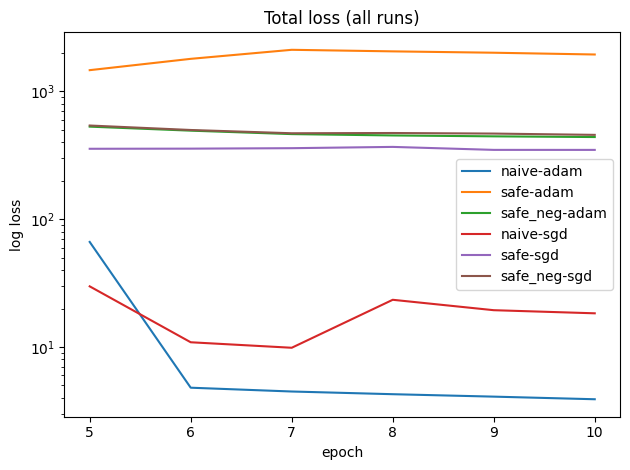

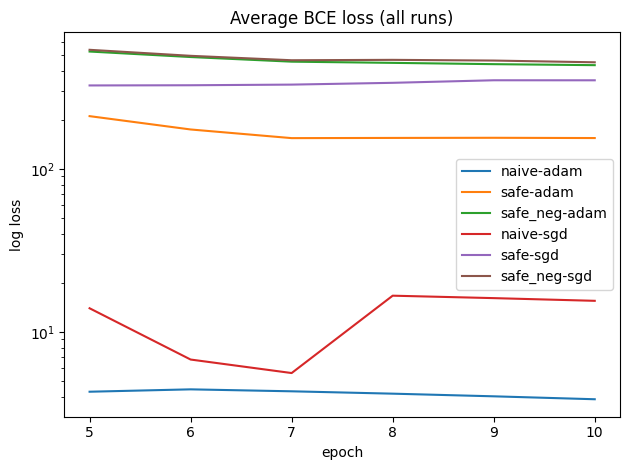

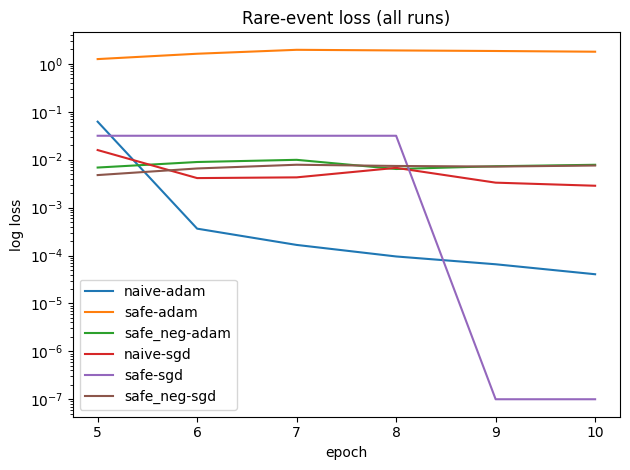

In [15]:
plot_all_loss(results, show_log=True)

## Accuracies

In [18]:
_ = eval_all(results, X_test, y_test, SIGMA, SAMPLES_EVAL)

Accuracy: 63.96%  (CI 95%: [62.63%, 65.28%])
Robust Accuracy: 63.96415%  (CI 95%: [62.80876%, 65.35857%])
Conditional Robust Accuracy: 100.00000%  (CI 95%: [100.00000%, 100.00000%])
Accuracy: 68.96%  (CI 95%: [67.67%, 70.23%])
Robust Accuracy: 69.33267%  (CI 95%: [68.13745%, 70.59811%])
Conditional Robust Accuracy: 98.88793%  (CI 95%: [98.59908%, 99.14789%])
Accuracy: 36.04%  (CI 95%: [34.72%, 37.37%])
Robust Accuracy: 35.98606%  (CI 95%: [34.60134%, 37.16160%])
Conditional Robust Accuracy: 99.86180%  (CI 95%: [99.72360%, 99.97236%])
Accuracy: 63.96%  (CI 95%: [62.63%, 65.28%])
Robust Accuracy: 63.98407%  (CI 95%: [62.80876%, 65.35906%])
Conditional Robust Accuracy: 100.00000%  (CI 95%: [100.00000%, 100.00000%])
Accuracy: 63.96%  (CI 95%: [62.63%, 65.28%])
Robust Accuracy: 63.96415%  (CI 95%: [62.80876%, 65.35857%])
Conditional Robust Accuracy: 100.00000%  (CI 95%: [100.00000%, 100.00000%])
Accuracy: 36.04%  (CI 95%: [34.72%, 37.37%])
Robust Accuracy: 36.03586%  (CI 95%: [34.64143%, 37